In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import emoji
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from string import punctuation
from unidecode import unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tawfekh-d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tawfekh-d/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tawfekh-d/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tawfekh-d/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/tawfekh-d/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# 1. MODEL FOR 3 Classes

In [2]:
#analysis_data1=pd.read_csv('twitter_training.csv',names=["Tweet ID","entity","sentiment","Tweet content"])
column_names = ["target", "id", "date", "flag", "user", "text"]
analysis_data1=pd.read_csv('data/twitter_dataset.csv')
#encoding="ISO-8859-1",names=column_names)


def read_data(data):
    print("Aperçu des données :")
    print(data.head(5))
    # Afficher les informations sur le DataFrame
    print("\nInformations sur les données :")
    print(data.info())
    print(" \n Taille : \n",data.shape)


## Read data

In [3]:
print("----- Données d’apprentissage 3 classes --------- \n")
#analysis_data1=analysis_data1.drop(columns = ['Unnamed'], inplace = True)
read_data(analysis_data1)


----- Données d’apprentissage 3 classes --------- 

Aperçu des données :
   Unnamed: 0                                              tweet  sentiment
0           0  is upset that he can't update his Facebook by ...        0.0
1           1  @Kenichan I dived many times for the ball. Man...        0.0
2           2    my whole body feels itchy and like its on fire         0.0
3           3  @nationwideclass no, it's not behaving at all....        0.0
4           4                      @Kwesidei not the whole crew         0.0

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142403 entries, 0 to 3142402
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   tweet       object 
 2   sentiment   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 71.9+ MB
None
 
 Taille : 
 (3142403, 3)


In [4]:
analysis_data1 = analysis_data1.drop('Unnamed: 0', axis=1)
read_data(analysis_data1)

Aperçu des données :
                                               tweet  sentiment
0  is upset that he can't update his Facebook by ...        0.0
1  @Kenichan I dived many times for the ball. Man...        0.0
2    my whole body feels itchy and like its on fire         0.0
3  @nationwideclass no, it's not behaving at all....        0.0
4                      @Kwesidei not the whole crew         0.0

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142403 entries, 0 to 3142402
Data columns (total 2 columns):
 #   Column     Dtype  
---  ------     -----  
 0   tweet      object 
 1   sentiment  float64
dtypes: float64(1), object(1)
memory usage: 47.9+ MB
None
 
 Taille : 
 (3142403, 2)


In [5]:
sentiment_value = analysis_data1['sentiment'].value_counts().reset_index()
sentiment_value

,sentiment,count
0,0.0,1570067
1,1.0,1561529
2,2.0,10725


#### Reduction nombre enregistrement dataset

In [6]:
def reduced_dim(data,nb_positive,nb_negative,nb_neutre):
    num_rows = {
        0.0:nb_negative ,#570000,
        1.0:nb_positive ,#560000,
        2.0:nb_neutre, #10725  
    }
    data = data.groupby('sentiment').apply(lambda x: x.sample(num_rows[x.name]))
    # Réinitialiser l'index du DataFrame
    data = data.reset_index(drop=True)
    return data


In [7]:
print("----- Données d’apprentissage 3 classes Apres reduction --------- \n")
analysis_data1=reduced_dim(analysis_data1,100000,100000,10725)
read_data(analysis_data1)

----- Données d’apprentissage 3 classes Apres reduction --------- 

Aperçu des données :
                                               tweet  sentiment
0  sadly i didnt laugh but singapore trending rem...        0.0
1   urghhh dance recital and sickk i have no voiceee        0.0
2                         @lainepgrey nope hes gone         0.0
3  lol i nearly forgot about this friday i wanna ...        0.0
4                                       Life's bad.         0.0

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210725 entries, 0 to 210724
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   tweet      210725 non-null  object 
 1   sentiment  210725 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.2+ MB
None
 
 Taille : 
 (210725, 2)


In [8]:
sentiment_value = analysis_data1['sentiment'].value_counts().reset_index()
sentiment_value

,sentiment,count
0,0.0,100000
1,1.0,100000
2,2.0,10725


## Preprocessing

In [9]:
emojis = {
    ":*": "kiss",
    ":-*": "kiss",
    ":x": "kiss",
    ":-)": "happy",
    ":-))": "happy",
    ":-)))": "happy",
    ":-))))": "happy",
    ":-)))))": "happy",
    ":-))))))": "happy",
    ":)": "happy",
    ":))": "happy",
    ":)))": "happy",
    ":))))": "happy",
    ":)))))": "happy",
    ":))))))": "happy",
    ":)))))))": "happy",
    ":o)": "happy",
    ":]": "happy",
    ":3": "happy",
    ":c)": "happy",
    ":>": "happy",
    "=]": "happy",
    "8)": "happy",
    "=)": "happy",
    ":}": "happy",
    ":^)": "happy",
    "|;-)": "happy",
    ":'-)": "happy",
    ":')": "happy",
    "\\o/": "happy",
    "*\\0/*": "happy",
    ":-D": "laugh",
    ":D": "laugh",
    "8-D": "laugh",
    "8D": "laugh",
    "x-D": "laugh",
    "xD": "laugh",
    "X-D": "laugh",
    "XD": "laugh",
    "=-D": "laugh",
    "=D": "laugh",
    "=-3": "laugh",
    "=3": "laugh",
    "B^D": "laugh",
    ">:[": "sad",
    ":-(": "sad",
    ":-((": "sad",
    ":-(((": "sad",
    ":-((((": "sad",
    ":-(((((": "sad",
    ":-((((((": "sad",
    ":-(((((((": "sad",
    ":(": "sad",
    ":((": "sad",
    ":(((": "sad",
    ":((((": "sad",
    ":(((((": "sad",
    ":((((((": "sad",
    ":(((((((": "sad",
    ":((((((((": "sad",
    ":-c": "sad",
    ":c": "sad",
    ":-<": "sad",
    ":<": "sad",
    ":-[": "sad",
    ":[": "sad",
    ":{": "sad",
    ":-||": "sad",
    ":@": "sad",
    ":'-(": "sad",
    ":'(": "sad",
    "D:<": "sad",
    "D:": "sad",
    "D8": "sad",
    "D;": "sad",
    "D=": "sad",
    "DX": "sad",
    "v.v": "sad",
    "D-':": "sad",
    "(>_<)": "sad",
    ":|": "sad",
    ">:O": "surprise",
    ":-O": "surprise",
    ":-o": "surprise",
    ":O": "surprise",
    "°o°": "surprise",
    "o_O": "surprise",
    "o_0": "surprise",
    "o.O": "surprise",
    "o-o": "surprise",
    "8-0": "surprise",
    "|-O": "surprise",
    ";-)": "wink",
    ";)": "wink",
    "*-)": "wink",
    "*)": "wink",
    ";-]": "wink",
    ";]": "wink",
    ";D": "wink",
    ";^)": "wink",
    ":-,": "wink",
    ">:P": "tong",
    ":-P": "tong",
    ":P": "tong",
    "X-P": "tong",
    "x-p": "tong",
    "xp": "tong",
    "XP": "tong",
    ":-p": "tong",
    ":p": "tong",
    "=p": "tong",
    ":-Þ": "tong",
    ":Þ": "tong",
    ":-b": "tong",
    ":b": "tong",
    ":-&": "tong",
    ">:\\": "annoyed",
    ">:/": "annoyed",
    ":-/": "annoyed",
    ":-.": "annoyed",
    ":/": "annoyed",
    ":\\": "annoyed",
    "=/": "annoyed",
    "=\\": "annoyed",
    ":L": "annoyed",
    "=L": "annoyed",
    ":S": "annoyed",
    ">.<": "annoyed",
    ":-|": "annoyed",
    "<:-|": "annoyed",
    ":-X": "seallips",
    ":X": "seallips",
    ":-#": "seallips",
    ":#": "seallips",
    "O:-)": "angel",
    "0:-3": "angel",
    "0:3": "angel",
    "0:-)": "angel",
    "0:)": "angel",
    "0;^)": "angel",
    ">:)": "devil",
    ">:D": "devil",
    ">:-D": "devil",
    ">;)": "devil",
    ">:-)": "devil",
    "}:-)": "devil",
    "}:)": "devil",
    "3:-)": "devil",
    "3:)": "devil",
    "o/\\o": "highfive",
    "^5": "highfive",
    ">_>^": "highfive",
    "^<_<": "highfive",
    "<3": "heart",
    "*:": "kiss",
    "*-:": "kiss",
    "x:": "kiss",
    "(-:": "happy",
    "((-:": "happy",
    "(((-:": "happy",
    "((((-:": "happy",
    "(((((-:": "happy",
    "((((((-:": "happy",
    "(:": "happy",
    "((:": "happy",
    "(((:": "happy",
    "((((:": "happy",
    "(((((:": "happy",
    "((((((:": "happy",
    "(((((((:": "happy",
    "(o:": "happy",
    "[:": "happy",
    "<:": "happy",
    "[=": "happy",
    "(=": "happy",
    "{:": "happy",
    "(-':": "happy",
    "(':": "happy",
    "]:<": "sad",
    ")-:": "sad",
    "))-:": "sad",
    ")))-:": "sad",
    "))))-:": "sad",
    ")))))-:": "sad",
    "))))))-:": "sad",
    ")))))))-:": "sad",
    "):": "sad",
    ")):": "sad",
    "))):": "sad",
    ")))):": "sad",
    "))))):": "sad",
    ")))))):": "sad",
    "))))))):": "sad",
    ")))))))):": "sad",
    ">-:": "sad",
    ">:": "sad",
    "]-:": "sad",
    "]:": "sad",
    "}:": "sad",
    "||-:": "sad",
    "@:": "sad",
    ")-':": "sad",
    ")':": "sad",
    "|:": "sad",
    "O:<": "surprise",
    "O-:": "surprise",
    "o-:": "surprise",
    "O:": "surprise",
    ".-:": "annoyed",
    "|-:": "annoyed",
    "|-:>": "annoyed",
    "#-:": "seallips",
    "#:": "seallips",
    "(-:O": "angel",
    "(-:0": "angel",
    "(:0": "angel",
    "(:<": "devil",
    "(-:<": "devil",
    "(-:{": "devil",
    "(:{": "devil",
    ":-d": "laugh",
    ":d": "laugh",
    "8-d": "laugh",
    "8d": "laugh",
    "x-d": "laugh",
    "xd": "laugh",
    "=-d": "laugh",
    "=d": "laugh",
    "b^d": "laugh",
    "d:<": "sad",
    "d:": "sad",
    "d8": "sad",
    "d;": "sad",
    "d=": "sad",
    "dx": "sad",
    "d-':": "sad",
    ">:o": "surprise",
    ":o": "surprise",
    "o_o": "surprise",
    "o.o": "surprise",
    "|-o": "surprise",
    ";d": "wink",
    ">:p": "tong",
    ":-þ": "tong",
    ":þ": "tong",
    ":l": "annoyed",
    "=l": "annoyed",
    ":s": "annoyed",
    ":-x": "seallips",
    "o:-)": "angel",
    ">:d": "devil",
    ">:-d": "devil",
    "o:<": "surprise",
    "o:": "surprise",
    "(-:o": "angel"
}
def str2emoji(tweet):
    for pos,ej in enumerate(tweet):
        if ej in emojis:
            tweet[pos]=emojis[ej]
    return tweet

In [10]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
nonstopwords = set(('not','no','nor','never'))
stopwords = set(stopwords.words('english'))-nonstopwords

### supression valeur null

In [11]:
#-------------------ESSAYER D"AFFICHER LISTE AU LIEU INDEX________________
def dropNan_value(data):
    index_with_nan = data.index[data.isnull().any(axis=1)]
    print("___________-Index of Nan_value : \n",index_with_nan)
    print("___________-number of Nan_value : \n",data.isnull().any(axis=1).value_counts())
    
   # print(data.shape())
    data = data.dropna()  # Drop rows with any NaN values
    print("____________After dropping nan_value :\n",data.index[data.isnull().any(axis=1)])
   # print(data.shape())
    return data
analysis_data1=dropNan_value(analysis_data1)

___________-Index of Nan_value : 
 Index([], dtype='int64')
___________-number of Nan_value : 
 False    210725
Name: count, dtype: int64
____________After dropping nan_value :
 Index([], dtype='int64')


### Normalisation =>Tokenisation => Lemmatization =>Pos tagging

In [12]:
def preprocess(txt):
    #txt = txt.lower() # Convert to lowercase
    txt = re.sub(r"\\u2019","'",txt)
    txt = re.sub(r"\\u002c","'",txt)
    txt = ' '.join(str2emoji(unidecode(txt).lower().split()))
    txt = re.sub(r'http\S+', '', txt)
    txt = re.sub(r'\S+@\S+', '', txt)
    txt = re.sub(r'\d{1,2}/\d{1,2}/\d{4}', '', txt)
    txt = re.sub(r"\'ve","have",txt)
    txt = re.sub(r"can\'t","cannot",txt)
    txt = re.sub(r"n\'t","not",txt)
    txt = re.sub(r"\'re","are",txt)
    txt = re.sub(r"\'d","would",txt)
    txt = re.sub(r"\'ll","will",txt)
    txt = re.sub(r"\'s","",txt)
    txt = re.sub(r"\'n","",txt)
    txt = re.sub(r"\'m","am",txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#\w+', '', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else
    lemmatizer.lemmatize(i) for i,j in pos_tag(tokenizer.tokenize(txt))]
    txt = [i for i in txt if (i not in stopwords) and (i not in punctuation)]
    txt = ' '.join(txt)
    return txt

In [13]:
def data_preprocessing(data,tweet):
    data['tweet_desc']=data[tweet].apply(lambda x:preprocess(x))
    return data['tweet_desc']

In [14]:
analysis_data1.head()

,tweet,sentiment
0,sadly i didnt laugh but singapore trending rem...,0.0
1,urghhh dance recital and sickk i have no voiceee,0.0
2,@lainepgrey nope hes gone,0.0
3,lol i nearly forgot about this friday i wanna ...,0.0
4,Life's bad.,0.0


In [19]:
tweet_preprocessed1=data_preprocessing(analysis_data1,'tweet')
analysis_data1.to_csv('data/twitter_dataset3_preprocessed.csv',index='false')

In [21]:
print("\n ----- Affiche tweet apres pretraitement des tweets --------- \n DATASET avec 3 Classes")
print(analysis_data1.head(3))


 ----- Affiche tweet apres pretraitement des tweets --------- 
 DATASET avec 3 Classes
                                               tweet  sentiment  \
0  sadly i didnt laugh but singapore trending rem...        0.0   
1   urghhh dance recital and sickk i have no voiceee        0.0   
2                         @lainepgrey nope hes gone         0.0   

                                          tweet_desc  \
0  sadly didnt laugh singapore trending remind do...   
1              urghhh dance recital sickk no voiceee   
2                                        nope hes go   

                                  tweet_preprocessed  
0  sadly didnt laugh singapore trending remind do...  
1              urghhh dance recital sickk no voiceee  
2                                        nope hes go  


In [22]:
target_df = analysis_data1['sentiment'].value_counts().reset_index()
target_df

,sentiment,count
0,0.0,100000
1,1.0,100000
2,2.0,10725


In [23]:
print('---> ',analysis_data1['sentiment'].unique())


--->  [0. 1. 2.]


## TOKENIZATION & PADDING  -AND split data

### TOKENIZATION & PADDING 

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=95
def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(filters=' ')
    tokenizer.fit_on_texts(tweet_preprocessed1)
    word_index=tokenizer.word_index
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X,maxlen=MAX_LEN)
    # return sequences
    return X, tokenizer,word_index

def show_tokenize_pad_sequences(text):
    print('Before Tokenization & Padding \n', text[0])
    X, tokenizer,word_index = tokenize_pad_sequences(text)
    print('After Tokenization & Padding \n', X[0])

2024-04-19 15:27:53.469941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 15:27:53.470074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 15:27:53.558432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 15:27:53.773633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 15:27:55.582417: W tensorflow/compiler/tf2

In [25]:
X1=analysis_data1['tweet_desc']
Y1=analysis_data1['sentiment']
X1, tokenizer,word_index1 = tokenize_pad_sequences(X1)
show_tokenize_pad_sequences(tweet_preprocessed1)

Before Tokenization & Padding 
 sadly didnt laugh singapore trending remind dont live no
After Tokenization & Padding 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  799  328  239 1995 3740  807  100  146    8]


In [26]:
print("X_1.shape:", X1.shape)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

X_1.shape: (210725, 95)
Vocabulary Size : 75475


In [27]:
print('\n ---> ',Y1.unique())


 --->  [0. 1. 2.]


### Split data

In [28]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)
print("Shape of X1_train: ", X1_train.shape)
print("Shape of X1_test: ", X1_test.shape)

Shape of X1_train:  (147507, 95)
Shape of X1_test:  (63218, 95)


In [29]:
print(" X1_train: ", X1_train)
print("X1_test: ", X1_test)

 X1_train:  [[    0     0     0 ...   200  1611  4601]
 [    0     0     0 ...  1114   353    78]
 [    0     0     0 ...     3    27    34]
 ...
 [    0     0     0 ...     9   513   944]
 [    0     0     0 ...   402    50    19]
 [    0     0     0 ... 54542   121  1366]]
X1_test:  [[   0    0    0 ...  509 1264    4]
 [   0    0    0 ...    0  162  152]
 [   0    0    0 ... 8531  638 5623]
 ...
 [   0    0    0 ...  291 7689 2120]
 [   0    0    0 ...  445    5   47]
 [   0    0    0 ...  145   27  616]]


In [30]:
print('\n Y1_test---> ',Y1_test)
print('\n Y1_train---> ',Y1_train)


 Y1_test--->  115632    1.0
34907     0.0
36614     0.0
193371    1.0
111552    1.0
         ... 
80084     0.0
204223    2.0
180315    1.0
148991    1.0
177054    1.0
Name: sentiment, Length: 63218, dtype: float64

 Y1_train--->  99758     0.0
207267    2.0
93986     0.0
115071    1.0
197166    1.0
         ... 
119879    1.0
103694    1.0
131932    1.0
146867    1.0
121958    1.0
Name: sentiment, Length: 147507, dtype: float64


## Encoding Y

In [31]:
### Encoder les étiquettes en one-hot :

from tensorflow.keras.utils import to_categorical

Y1_train_one_hot = to_categorical(Y1_train)
Y1_test_one_hot = to_categorical(Y1_test)

In [32]:
print('\n Y1_train_one_hot---> ',Y1_train_one_hot)
print('\n Y1_test_one_hot---> ',Y1_test_one_hot)


 Y1_train_one_hot--->  [[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]

 Y1_test_one_hot--->  [[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## Word Embedding => GloVe

In [33]:

import tensorflow as tf

GLOVE_EMB ='glove.6B/glove.6B.300d.txt'  #'glove.twitter.27B/glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 300 #200
# LR = 1e-3
BATCH_SIZE = 50
EPOCHS = 7
#MODEL_PATH = '/Projet/best_model.hdf5'
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


## Pre_trained Model => 3 classe

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
def getModel():
    embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_LEN,
                                          trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)),
        Bidirectional(LSTM(64, return_sequences=True)),
        # Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(3, activation='softmax'),
    ])
    return model

In [35]:
training_model = getModel()

2024-04-19 15:31:19.516713: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90570000 exceeds 10% of free system memory.
2024-04-19 15:31:19.560658: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90570000 exceeds 10% of free system memory.
2024-04-19 15:31:19.579523: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90570000 exceeds 10% of free system memory.
2024-04-19 15:31:19.912882: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90570000 exceeds 10% of free system memory.


### Training Model

In [36]:
training_model.summary()
training_model.compile(optimizer=Adam(), loss='categorical_crossentropy',
              metrics=['accuracy'])
history = training_model.fit(X1_train, Y1_train_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X1_test, Y1_test_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 300)           22642500  
                                                                 
 bidirectional (Bidirection  (None, 95, 128)           186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 95, 128)           98816     
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

2024-04-19 15:31:36.297468: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56052660 exceeds 10% of free system memory.


Epoch 1/7
2951/2951 [==============================] - 588s 198ms/step - loss: 0.5518 - accuracy: 0.7370 - val_loss: 0.5131 - val_accuracy: 0.7654
Epoch 2/7
2951/2951 [==============================] - 674s 228ms/step - loss: 0.4980 - accuracy: 0.7705 - val_loss: 0.4999 - val_accuracy: 0.7710
Epoch 3/7
2951/2951 [==============================] - 669s 227ms/step - loss: 0.4724 - accuracy: 0.7836 - val_loss: 0.4946 - val_accuracy: 0.7757
Epoch 4/7
2951/2951 [==============================] - 548s 186ms/step - loss: 0.4502 - accuracy: 0.7957 - val_loss: 0.4994 - val_accuracy: 0.7740
Epoch 5/7
2951/2951 [==============================] - 577s 196ms/step - loss: 0.4305 - accuracy: 0.8067 - val_loss: 0.4927 - val_accuracy: 0.7796
Epoch 6/7
2951/2951 [==============================] - 551s 187ms/step - loss: 0.4129 - accuracy: 0.8155 - val_loss: 0.4984 - val_accuracy: 0.7804
Epoch 7/7
2951/2951 [==============================] - 540s 183ms/step - loss: 0.3955 - accuracy: 0.8241 - val_loss: 0

### Evaluation 

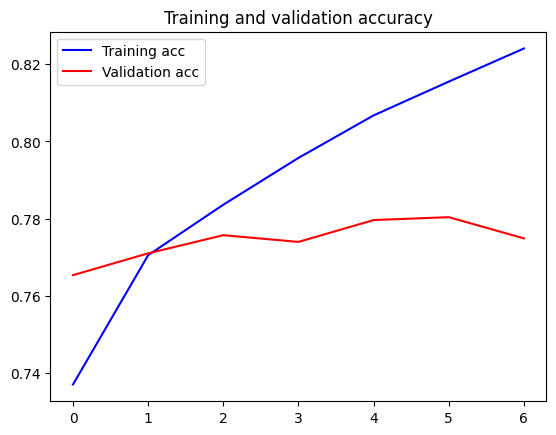

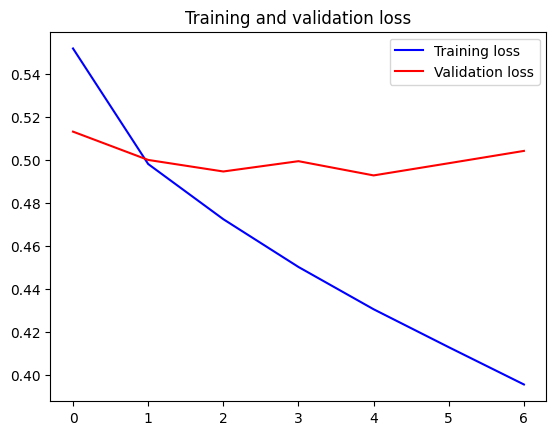

In [37]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = training_model.predict(X1_test)

1976/1976 [==============================] - 81s 41ms/step


In [39]:
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(Y1_test_one_hot, axis=1), y_pred_classes))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     29865
           1       0.79      0.74      0.76     30146
           2       0.91      0.82      0.86      3207

    accuracy                           0.77     63218
   macro avg       0.82      0.79      0.80     63218
weighted avg       0.78      0.77      0.77     63218



In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_score, recall_score, f1_score
# Calculate metrics
accuracy = np.mean(y_pred_classes == np.argmax(Y1_test_one_hot, axis=1))
precision = precision_score(np.argmax(Y1_test_one_hot, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(Y1_test_one_hot, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(Y1_test_one_hot, axis=1), y_pred_classes, average='weighted')

# Print metrics
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

Accuracy: 0.7749
Precision: 0.7766
Recall: 0.7749
F1 Score: 0.7749


In [43]:
# from mlxtend.plotting import plot_confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(Y1_test_one_hot, axis=1), y_pred_classes)
Y1_test = Y1_test.map({0.0:'Negative', 1.0:'Positive', 2.0:'Neutral'}) 


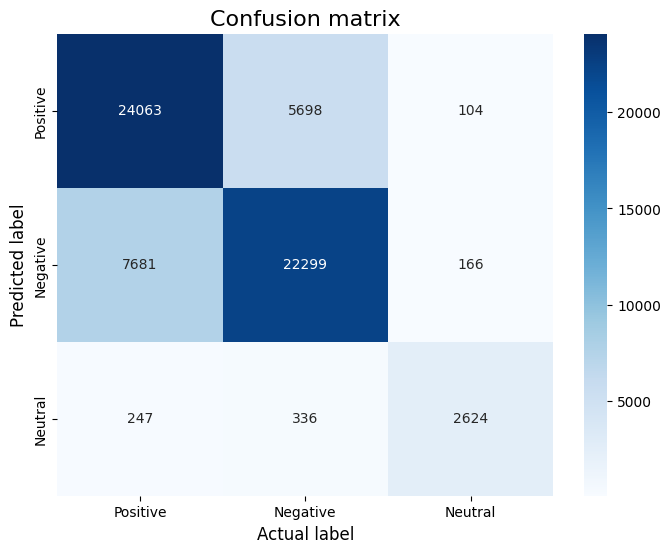

In [44]:
def plot_confusion_matrix(confusion_mat,Y_test):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mat, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=Y1_test.unique(),
                yticklabels=Y1_test.unique())
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(cnf_matrix, Y1_test)

In [45]:
import pickle
training_model.save("Models/sentiment_model_pretrained_3classe.h5")
training_model.save_weights("Models/Model Weights/weights")
# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

/home/tawfekh-d/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 2. MODEL FOR 7 classes =>Transfer Learning

###  _-> Read Data

In [115]:
analysis_data7 = pd.read_csv('data/2018-Valence-oc-En-train.txt', sep="\t")
analysis_data7_dev = pd.read_csv('data/2018-Valence-oc-En-dev.txt', sep="\t")
print("\n ------Données d’apprentissage 7 classes ---------- \n")
read_data(analysis_data7)


 ------Données d’apprentissage 7 classes ---------- 

Aperçu des données :
              ID                                              Tweet  \
0  2017-En-30153                   @liamch88 yeah! :) playing well    
1  2017-En-40929  At least I don't have a guy trying to discoura...   
2  2017-En-22012  UPLIFT: If you're still discouraged it means y...   
3  2017-En-30837  ...at your age, the heyday in the blood is tam...   
4  2017-En-30838  i was so embarrassed when she saw us i was lik...   

  Affect Dimension                                    Intensity Class  
0          valence  0: neutral or mixed emotional state can be inf...  
1          valence  0: neutral or mixed emotional state can be inf...  
2          valence  0: neutral or mixed emotional state can be inf...  
3          valence  0: neutral or mixed emotional state can be inf...  
4          valence  -2: moderately negative emotional state can be...  

Informations sur les données :
<class 'pandas.core.frame.DataFra

### _-> Preprocessing

In [116]:
analysis_data7=dropNan_value(analysis_data7)
analysis_data7.head()

___________-Index of Nan_value : 
 Index([], dtype='int64')
___________-number of Nan_value : 
 False    1181
Name: count, dtype: int64
____________After dropping nan_value :
 Index([], dtype='int64')


,ID,Tweet,Affect Dimension,Intensity Class
0,2017-En-30153,@liamch88 yeah! :) playing well,valence,0: neutral or mixed emotional state can be inf...
1,2017-En-40929,At least I don't have a guy trying to discoura...,valence,0: neutral or mixed emotional state can be inf...
2,2017-En-22012,UPLIFT: If you're still discouraged it means y...,valence,0: neutral or mixed emotional state can be inf...
3,2017-En-30837,"...at your age, the heyday in the blood is tam...",valence,0: neutral or mixed emotional state can be inf...
4,2017-En-30838,i was so embarrassed when she saw us i was lik...,valence,-2: moderately negative emotional state can be...


In [117]:
def preprocess(txt):
    #txt = txt.lower() # Convert to lowercase
    txt = re.sub(r"\\u2019","'",txt)
    txt = re.sub(r"\\u002c","'",txt)
    txt = ' '.join(str2emoji(unidecode(txt).lower().split()))
    txt = re.sub(r'http\S+', '', txt)
    txt = re.sub(r'\S+@\S+', '', txt)
    txt = re.sub(r'\d{1,2}/\d{1,2}/\d{4}', '', txt)
    txt = re.sub(r"\'ve","have",txt)
    txt = re.sub(r"can\'t","cannot",txt)
    txt = re.sub(r"n\'t","not",txt)
    txt = re.sub(r"\'re","are",txt)
    txt = re.sub(r"\'d","would",txt)
    txt = re.sub(r"\'ll","will",txt)
    txt = re.sub(r"\'s","",txt)
    txt = re.sub(r"\'n","",txt)
    txt = re.sub(r"\'m","am",txt)
    txt = re.sub(r'@\w+', '', txt)
    txt = re.sub(r'#\w+', '', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('[^a-zA-Z]', ' ', txt)

    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(txt) # tokenizing the text
    pos_tags = pos_tag(tokens) # tagging the tokens

    txt = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in pos_tags]
    txt = [i for i in txt if (i not in stopwords) and (i not in punctuation)]
    txt = ' '.join(txt)
    return txt

In [118]:
def data_preprocessing(data,tweet):
    data['tweet_desc']=data[tweet].apply(lambda x:preprocess(x))
    return data['tweet_desc']

In [119]:
from nltk.tokenize import TweetTokenizer
tweet_preprocessed7=data_preprocessing(analysis_data7,'Tweet')
print("\n ----- |||||||--------- \n Preprocessed DATASET of 7 Classes")
print(tweet_preprocessed7.head())
analysis_data7.to_csv('data/2018-Valence-oc-En-train_preprocessed.csv',index='false')


 ----- |||||||--------- 
 Preprocessed DATASET of 7 Classes
0                              yeah happy playing well
1    least donot guy try discourage anymore want ne...
2    uplift youare still discourage mean youare lis...
3                                age heyday blood tame
4    embarrassed saw u like knvfkkjg think weare st...
Name: tweet_desc, dtype: object


In [120]:
print('\n Type of sentiment--->  ; \n ',analysis_data7['Intensity Class'].unique())
target_df2 = analysis_data7['Intensity Class'].value_counts().reset_index() 
target_df2


 Type of sentiment--->  ; 
  ['0: neutral or mixed emotional state can be inferred'
 '-2: moderately negative emotional state can be inferred'
 '-3: very negative emotional state can be inferred'
 '1: slightly positive emotional state can be inferred'
 '2: moderately positive emotional state can be inferred'
 '3: very positive emotional state can be inferred'
 '-1: slightly negative emotional state can be inferred']


,Intensity Class,count
0,0: neutral or mixed emotional state can be inf...,341
1,-2: moderately negative emotional state can be...,249
2,1: slightly positive emotional state can be in...,167
3,-3: very negative emotional state can be inferred,129
4,3: very positive emotional state can be inferred,125
5,2: moderately positive emotional state can be ...,92
6,-1: slightly negative emotional state can be i...,78


### _-> TOKENIZATION & PADDING  -AND split data

In [121]:
X7=analysis_data7['tweet_desc']
Y7=analysis_data7['Intensity Class']
X7, tokenizer,word_index = tokenize_pad_sequences(X7)
show_tokenize_pad_sequences(tweet_preprocessed7)

Before Tokenization & Padding 
 yeah happy playing well
After Tokenization & Padding 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   73   54 2092   34]


In [122]:
### Split data with data_dev
X7_train=X7
Y7_train=Y7

tweet_preprocessed7_test=data_preprocessing(analysis_data7_dev,'Tweet')
analysis_data7_dev.to_csv('data/2018-Valence-oc-En-dev_preprocessed.csv',index='false')
X7_test=analysis_data7_dev['tweet_desc']
Y7_test=analysis_data7_dev['Intensity Class']
X7_test, tokenizer,word_index = tokenize_pad_sequences(X7_test)
show_tokenize_pad_sequences(tweet_preprocessed7)


Before Tokenization & Padding 
 yeah happy playing well
After Tokenization & Padding 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   73   54 2092   34]


In [123]:
# Split data
# X7_train, X7_test, Y7_train, Y7_test = train_test_split(X7, Y7, test_size=0.2, random_state=42)
# print("Shape of X7_train: ", X7_train.shape)
# print("Shape of X7_test: ", X7_test.shape)

In [124]:
print(" Shape of X7_train: ", X7_train.shape)
print("\n --_> : ", X7_train)
print("\n \n Shape of X7_test: ", X7_test.shape)
print("\n --_> : ", X7_test)


 Shape of X7_train:  (1181, 95)

 --_> :  [[   0    0    0 ...   54 2092   34]
 [   0    0    0 ...  609 7401 3025]
 [   0    0    0 ... 1745   35 1514]
 ...
 [   0    0    0 ... 3900  802 2580]
 [   0    0    0 ...    0    0 3409]
 [   0    0    0 ...   67  140 4777]]

 
 Shape of X7_test:  (449, 95)

 --_> :  [[    0     0     0 ...   313    24   333]
 [    0     0     0 ...  1875    24  1456]
 [    0     0     0 ...  2583  5813     4]
 ...
 [    0     0     0 ...  1638   457  2661]
 [    0     0     0 ...    17   144   144]
 [    0     0     0 ... 33663 19281  4518]]


In [125]:
print("\n  Shape of Y7_train: ", Y7_train.shape)
print("\n --_> : ", Y7_train)
print("\n \nShape of Y7_test: ", Y7_test.shape)
print("\n --_> : ", Y7_test)


  Shape of Y7_train:  (1181,)

 --_> :  0       0: neutral or mixed emotional state can be inf...
1       0: neutral or mixed emotional state can be inf...
2       0: neutral or mixed emotional state can be inf...
3       0: neutral or mixed emotional state can be inf...
4       -2: moderately negative emotional state can be...
                              ...                        
1176    1: slightly positive emotional state can be in...
1177    -2: moderately negative emotional state can be...
1178    1: slightly positive emotional state can be in...
1179    0: neutral or mixed emotional state can be inf...
1180    -2: moderately negative emotional state can be...
Name: Intensity Class, Length: 1181, dtype: object

 
Shape of Y7_test:  (449,)

 --_> :  0      -3: very negative emotional state can be inferred
1      -2: moderately negative emotional state can be...
2      -3: very negative emotional state can be inferred
3       3: very positive emotional state can be inferred
4  

### Encoding Y 

In [126]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Y7_train_encoded = label_encoder.fit_transform(Y7_train)
Y7_test_encoded = label_encoder.transform(Y7_test)

Y7_train_one_hot = to_categorical(Y7_train_encoded)
Y7_test_one_hot = to_categorical(Y7_test_encoded)

In [127]:
print("\n --_> Y7_train_one_hot: ", Y7_train_one_hot)
print("\n --_> Y7_test_one_hot: ", Y7_test_one_hot)


 --_> Y7_train_one_hot:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

 --_> Y7_test_one_hot:  [[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


### _-> Model Transfert learning 

In [128]:
def getTransfertModel(model):
    transfert_model = Sequential()
    for layer in model.layers[:-1]:
        transfert_model.add(layer)
    # Congeler les poids des couches pré-entraînées
    for layer in transfert_model.layers:
        layer.trainable = False
    transfert_model.add(Dense(150, activation='relu',name='dense1'))
    transfert_model.add(Dense(100, activation='relu',name='dense2'))
    # transfert_model.add(Dense(100, activation='relu',name='dense2'))
    transfert_model.add(Dense(60, activation='relu',name='dense3'))
    transfert_model.add(Dense(7, activation='softmax',name='dense4'))
    return transfert_model

In [129]:
from keras.models import load_model
tmodel=load_model("Models/sentiment_model_pretrained_3classe.h5") # load the model of 3 classe
tmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 300)           22642500  
                                                                 
 bidirectional (Bidirection  (None, 95, 128)           186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 95, 128)           98816     
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

In [130]:
transfertmodel=getTransfertModel(tmodel)
transfertmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 300)           22642500  
                                                                 
 bidirectional (Bidirection  (None, 95, 128)           186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 95, 128)           98816     
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense1 (Dense)              (None, 150)               19350     
                                                      

In [131]:
from tensorflow.keras.optimizers import RMSprop
transfertmodel.compile(optimizer=RMSprop(), loss='categorical_crossentropy',
              metrics=['accuracy'])
history = transfertmodel.fit(X7_train, Y7_train_one_hot, batch_size=BATCH_SIZE+5, epochs=EPOCHS+8,
                    validation_data=(X7_test, Y7_test_one_hot))

Epoch 1/15
22/22 [==============================] - 7s 152ms/step - loss: 1.7753 - accuracy: 0.2913 - val_loss: 1.7464 - val_accuracy: 0.3096
Epoch 2/15
22/22 [==============================] - 2s 101ms/step - loss: 1.6360 - accuracy: 0.3480 - val_loss: 1.6823 - val_accuracy: 0.3163
Epoch 3/15
22/22 [==============================] - 2s 100ms/step - loss: 1.5924 - accuracy: 0.3675 - val_loss: 1.6745 - val_accuracy: 0.3363
Epoch 4/15
22/22 [==============================] - 2s 101ms/step - loss: 1.5758 - accuracy: 0.3607 - val_loss: 1.6672 - val_accuracy: 0.3430
Epoch 5/15
22/22 [==============================] - 2s 99ms/step - loss: 1.5566 - accuracy: 0.3920 - val_loss: 1.6484 - val_accuracy: 0.3519
Epoch 6/15
22/22 [==============================] - 2s 107ms/step - loss: 1.5423 - accuracy: 0.3912 - val_loss: 1.6729 - val_accuracy: 0.3341
Epoch 7/15
22/22 [==============================] - 2s 96ms/step - loss: 1.5273 - accuracy: 0.4014 - val_loss: 1.6630 - val_accuracy: 0.3363
Epoch 8/

In [79]:
y7_pred = transfertmodel.predict(X7_test)

15/15 [==============================] - 2s 39ms/step


### Evaluation

In [80]:
y7_pred_classes = np.argmax(y7_pred, axis=1)
print(classification_report(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.36      0.43      0.39        95
           2       0.46      0.23      0.31        69
           3       0.34      0.63      0.44       105
           4       0.34      0.19      0.24        58
           5       0.00      0.00      0.00        35
           6       0.32      0.45      0.38        53

    accuracy                           0.35       449
   macro avg       0.26      0.28      0.25       449
weighted avg       0.31      0.35      0.31       449



/home/tawfekh-d/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tawfekh-d/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tawfekh-d/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:

# Calculate metrics
accuracy = np.mean(y7_pred_classes == np.argmax(Y7_test_one_hot, axis=1))
precision = precision_score(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes, average='weighted')
recall = recall_score(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes, average='weighted')
f1 = f1_score(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes, average='weighted')

# Print metrics
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))


Accuracy: 0.3519
Precision: 0.3090
Recall: 0.3519
F1 Score: 0.3101


/home/tawfekh-d/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


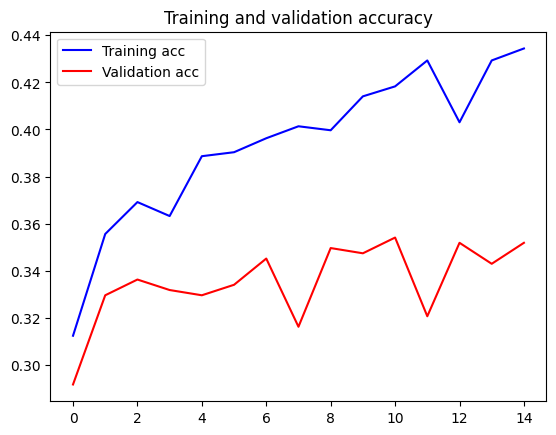

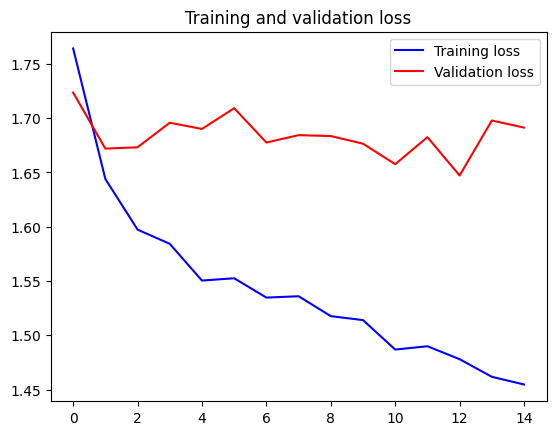

In [82]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

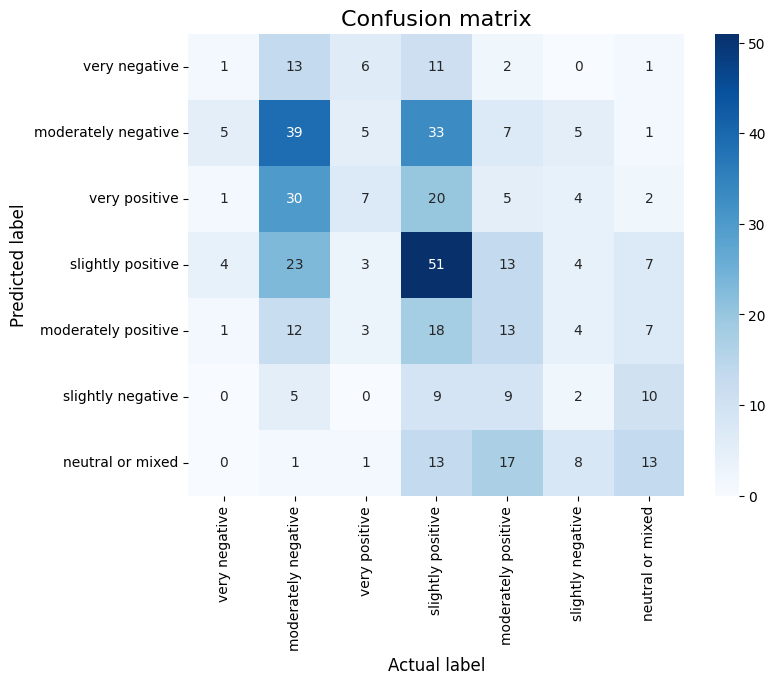

In [132]:
cnf_matrix = confusion_matrix(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes)
Y7_test = Y7_test.map({'0: neutral or mixed emotional state can be inferred':'neutral or mixed',
                       '-2: moderately negative emotional state can be inferred':'moderately negative',
                       '-3: very negative emotional state can be inferred':'very negative',
                       '1: slightly positive emotional state can be inferred':'slightly positive',
                       '2: moderately positive emotional state can be inferred':'moderately positive',
                       '3: very positive emotional state can be inferred':'very positive',
                       '-1: slightly negative emotional state can be inferred':'slightly negative'})

def plot_confusion_matrix(confusion_mat,Y7_test):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mat, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=Y7_test.unique(),
                yticklabels=Y7_test.unique())
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(cnf_matrix, Y7_test)

In [133]:
transfertmodel.save("Models/sentiment_transfertmodel_7classe.h5")

/home/tawfekh-d/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Early stopping

In [134]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
transfertmodel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfertmodel.fit(X7_train, Y7_train_one_hot, batch_size=BATCH_SIZE+5, epochs=EPOCHS+5,
                    validation_data=(X7_test, Y7_test_one_hot), callbacks=[early_stopping])
# (X7_train, Y7_train_one_hot, ,
                    # validation_data=(X7_test, Y7_test_one_hot))


Epoch 1/12
22/22 [==============================] - 10s 182ms/step - loss: 1.4300 - accuracy: 0.4471 - val_loss: 1.6758 - val_accuracy: 0.3563
Epoch 2/12
22/22 [==============================] - 2s 107ms/step - loss: 1.4144 - accuracy: 0.4513 - val_loss: 1.6847 - val_accuracy: 0.3563
Epoch 3/12
22/22 [==============================] - 3s 119ms/step - loss: 1.3943 - accuracy: 0.4522 - val_loss: 1.6830 - val_accuracy: 0.3497
Epoch 4/12
22/22 [==============================] - 3s 116ms/step - loss: 1.3922 - accuracy: 0.4547 - val_loss: 1.7083 - val_accuracy: 0.3252
Epoch 5/12
22/22 [==============================] - 3s 125ms/step - loss: 1.3956 - accuracy: 0.4589 - val_loss: 1.7126 - val_accuracy: 0.3274
Epoch 6/12
22/22 [==============================] - 3s 121ms/step - loss: 1.3832 - accuracy: 0.4708 - val_loss: 1.6860 - val_accuracy: 0.3497


In [135]:
y7_pred = transfertmodel.predict(X7_test)
y7_pred_classes = np.argmax(y7_pred, axis=1)

15/15 [==============================] - 2s 39ms/step


In [136]:
# Calculate metrics
accuracy = np.mean(y7_pred_classes == np.argmax(Y7_test_one_hot, axis=1))
precision = precision_score(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes, average='weighted')
recall = recall_score(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes, average='weighted')
f1 = f1_score(np.argmax(Y7_test_one_hot, axis=1), y7_pred_classes, average='weighted')

# Print metrics
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))


Accuracy: 0.3497
Precision: 0.3038
Recall: 0.3497
F1 Score: 0.3125


In [137]:
transfertmodel.save("Models/sentiment_transfertmodel_7classe_earlystopping.h5")

/home/tawfekh-d/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
